# Machine Learning Modelling: Remote Work Stress Level Prediction

## Overview
This notebook implements a machine learning pipeline to predict employee stress levels (Low/Medium/High). All exploratory data analysis was completed in `data_exploration.ipynb`.

**Research Question:** Can we accurately predict employee stress levels using workplace, demographic, and well-being indicators in remote/hybrid work settings?

**Modelling Strategy:**
1. Baseline comparison (Dummy classifier)
2. Two candidate models: Histogram Gradient Boosting and XGBoost
3. Cross-validated model selection using macro-F1 score
4. Hyperparameter tuning for best model
5. Final evaluation on held-out test set
6. Feature importance analysis

**Key Decisions from EDA:**
- Target: Stress_Level (3 balanced classes: Low/Medium/High)
- Excluded: Mental_Health_Condition & Productivity_Change (leakage risk)
- Excluded: Physical_Activity (32.6% missing)
- Primary metric: Macro-F1 (balances performance across all classes)

## 1. Set up and Imports

In [10]:
#importing libraries

#for data manipulation and visulaisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#for preprocessing and pipelines
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#for the models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

#for evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

#setting the random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#setting the visualisation style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

## 2. Data Loading and Preparation

Based on findings from `data_exploration.ipynb`:
- Dataset: 5,000 employees, 20 variables
- Target: Stress_Level (balanced classes: ~33% each)
- No missing values in target variable

In [11]:
# Load the dataset
df = pd.read_csv("../data/Impact_of_Remote_Work_on_Mental_Health.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['Stress_Level'].value_counts(normalize=True))

Dataset shape: (5000, 20)

Target distribution:
Stress_Level
High      0.3372
Medium    0.3338
Low       0.3290
Name: proportion, dtype: float64


## 3. Feature Selection and Preprocessing Setup

### Excluded Variables (from EDA insights):
- **Leakage risk**: Mental_Health_Condition, Productivity_Change (outcomes of stress)
- **High missingness**: Physical_Activity (32.6% missing)
- **Non-predictive**: Employee_ID, Gender, Industry, Region

### Feature Engineering Strategy:
- **Numeric** (4 features): Median imputation + standardization
- **Ordinal** (5 features): Preserve order, impute with mode
- **Nominal** (3 features): One-hot encoding

In [12]:
#features to exclude
excluded_features = ["Employee_ID", "Gender", "Industry", "Region","Mental_Health_Condition", "Productivity_Change", 
                     "Physical_Activity", "Stress_Level"]

# Numeric features
numeric_features = ["Age", "Years_of_Experience", "Hours_Worked_Per_Week", "Number_of_Virtual_Meetings"]

# Ordinal features (1-5 rating scales)
ordinal_features = ["Work_Life_Balance_Rating", "Social_Isolation_Rating", "Company_Support_for_Remote_Work"]

# Ordinal text features (need ordered encoding)
ordinal_text_features = {"Satisfaction_with_Remote_Work": ["Unsatisfied", "Neutral", "Satisfied"],
    "Sleep_Quality": ["Poor", "Average", "Good"]}

# Nominal features
nominal_features = ["Work_Location", "Job_Role", "Access_to_Mental_Health_Resources"]

print(f"Total features for modelling: {len(numeric_features) + len(ordinal_features) + len(ordinal_text_features) + len(nominal_features)}")
print(f"Numeric: {len(numeric_features)}")
print(f"Ordinal: {len(ordinal_features) + len(ordinal_text_features)}")
print(f"Nominal: {len(nominal_features)}")

Total features for modelling: 12
Numeric: 4
Ordinal: 5
Nominal: 3


## 4. Train-Test Split

80-20 stratified split to maintain class balance in both sets.

In [13]:
# Prepare X and y
X = df.drop(columns=excluded_features)
y = df["Stress_Level"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set:     {X_test.shape[0]:,} samples")

Training set: 4,000 samples
Test set:     1,000 samples


## 5. Preprocessing Pipeline

Create transformers for each feature type, preventing data leakage by fitting only on training data.

In [14]:
# Numeric: impute median, then standardize
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Ordinal numeric: impute mode
ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Ordinal text: encode in order, then impute
ordinal_text_transformers = []
for feature, categories in ordinal_text_features.items():
    transformer = Pipeline([
        ('encoder', OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value=-1)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    ordinal_text_transformers.append((f'ord_text_{feature}', transformer, [feature]))

# Nominal: impute then one-hot encode
nominal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_transformer, nominal_features)
    ] + ordinal_text_transformers,
    remainder='drop'
)

print("Preprocessing pipeline created")

Preprocessing pipeline created


## 6. Baseline Model

Dummy classifier (most frequent) establishes minimum performance threshold.

In [15]:
# Create and evaluate dummy classifier
dummy_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE))
])

dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_test)

baseline_f1 = f1_score(y_test, y_pred_dummy, average='macro')

print("BASELINE: Dummy Classifier (Most Frequent)")
print(f"\nAccuracy:        {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"F1-macro:        {baseline_f1:.4f}")
print(f"\nStrategy: Always predicts '{y_train.mode()[0]}'")
print("\nReal models must beat this baseline")

BASELINE: Dummy Classifier (Most Frequent)

Accuracy:        0.3370
F1-macro:        0.1680

Strategy: Always predicts 'High'

Real models must beat this baseline


## 7. Model Comparison with Cross-Validation

Compare two gradient boosting implementations:
1. **Histogram Gradient Boosting** (scikit-learn): Fast, handles missing values natively
2. **XGBoost**: Industry standard with advanced regularization

Both use 5-fold stratified cross-validation. Selection based on mean macro-F1.

In [16]:
# Encode target variable to numeric (XGBoost requirement)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define candidate models
candidate_models = {
    'Histogram Gradient Boosting': HistGradientBoostingClassifier(
        max_iter=200,
        max_depth=8,
        learning_rate=0.1,
        min_samples_leaf=20,
        random_state=RANDOM_STATE
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
}

# Setup 5-fold stratified CV
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring_metrics = {'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_weighted': 'f1_weighted'}

print("\nCROSS-VALIDATED MODEL COMPARISON")
print("\nEvaluating models...\n")

cv_results = []

for model_name, model in candidate_models.items():
    print(f"⏳ {model_name}...", end=' ')
    
    # Create pipeline
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
    
    # Use encoded y for cross-validation
    cv_scores = cross_validate(
        pipeline, X_train, y_train_encoded,
        cv=cv_splitter,
        scoring=scoring_metrics,
        n_jobs=-1,
        return_train_score=True
    )
    
    # Store results
    results = {
        'Model': model_name,
        'CV_F1_Macro': f"{cv_scores['test_f1_macro'].mean():.4f} ± {cv_scores['test_f1_macro'].std():.4f}",
        'CV_Accuracy': f"{cv_scores['test_accuracy'].mean():.4f} ± {cv_scores['test_accuracy'].std():.4f}",
        'Mean_F1': cv_scores['test_f1_macro'].mean(),
        'Train_F1': cv_scores['train_f1_macro'].mean()
    }
    cv_results.append(results)
    
    print(f"F1-macro: {results['CV_F1_Macro']}")

#Display results
cv_df = pd.DataFrame(cv_results).sort_values('Mean_F1', ascending=False)

print("\n" + "="*60)
print("RESULTS (sorted by F1-macro)")
print("="*60)
for _, row in cv_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  F1-macro:  {row['CV_F1_Macro']}")
    print(f"  Accuracy:  {row['CV_Accuracy']}")

# Select best model
best_model_name = cv_df.iloc[0]['Model']
best_f1_macro = cv_df.iloc[0]['Mean_F1']

print("\n" + "="*60)
print(f"🏆 SELECTED MODEL: {best_model_name}")
print("="*60)
print(f"CV F1-macro: {best_f1_macro:.4f}")
print(f"Improvement over baseline: +{(best_f1_macro - baseline_f1):.4f} ({((best_f1_macro/baseline_f1 - 1)*100):.1f}%)")

# Check overfitting
train_test_gap = cv_df.iloc[0]['Train_F1'] - cv_df.iloc[0]['Mean_F1']
if train_test_gap > 0.10:
    print(f"\n⚠ Warning: Potential overfitting (gap: {train_test_gap:.4f})")
else:
    print(f"\n✓ Good generalization (train-test gap: {train_test_gap:.4f})")


CROSS-VALIDATED MODEL COMPARISON

Evaluating models...

⏳ Histogram Gradient Boosting... F1-macro: 0.3273 ± 0.0209
⏳ XGBoost... F1-macro: 0.3304 ± 0.0121

RESULTS (sorted by F1-macro)

XGBoost:
  F1-macro:  0.3304 ± 0.0121
  Accuracy:  0.3307 ± 0.0123

Histogram Gradient Boosting:
  F1-macro:  0.3273 ± 0.0209
  Accuracy:  0.3275 ± 0.0211

🏆 SELECTED MODEL: XGBoost
CV F1-macro: 0.3304
Improvement over baseline: +0.1624 (96.6%)

⚠ Warning: Potential overfitting (gap: 0.6641)


## 8. Hyperparameter Tuning

RandomizedSearchCV with 30 iterations to optimize the selected model.


In [17]:
# Define parameter distributions
param_distributions = {
    'Histogram Gradient Boosting': {
        'classifier__max_iter': [100, 200, 300],
        'classifier__max_depth': [5, 8, 10, 15],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__min_samples_leaf': [10, 20, 30, 50],
        'classifier__max_leaf_nodes': [31, 50, 100, None]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7, 9],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__gamma': [0, 0.1, 0.2, 0.5]
    }
}

print("="*60)
print(f"HYPERPARAMETER TUNING: {best_model_name}")
print("="*60)
print("\nSearch: RandomizedSearchCV (30 iterations, 3-fold CV)")
print("Optimizing: f1_macro\n")

# Setup search
best_model = candidate_models[best_model_name]
tuning_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', best_model)])

random_search = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_distributions[best_model_name],
    n_iter=30,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

# Perform search
# Choose correct target depending on model
y_tune = y_train_encoded if best_model_name == "XGBoost" else y_train

# Perform search
random_search.fit(X_train, y_tune)

print("\n" + "="*60)
print("TUNING RESULTS")
print("="*60)
print(f"\nBest CV F1-macro: {random_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param.replace('classifier__', '')}: {value}")

improvement = random_search.best_score_ - best_f1_macro
if improvement > 0.001:
    print(f"\n✓ Tuning improved F1-macro by {improvement:.4f}")
else:
    print(f"\n→ Minimal improvement ({improvement:.4f}) - defaults were good")

# Use best model for final evaluation
final_model = random_search.best_estimator_

HYPERPARAMETER TUNING: XGBoost

Search: RandomizedSearchCV (30 iterations, 3-fold CV)
Optimizing: f1_macro

Fitting 3 folds for each of 30 candidates, totalling 90 fits

TUNING RESULTS

Best CV F1-macro: 0.3357

Best parameters:
  subsample: 0.8
  n_estimators: 200
  min_child_weight: 3
  max_depth: 3
  learning_rate: 0.1
  gamma: 0.1
  colsample_bytree: 1.0

✓ Tuning improved F1-macro by 0.0053


## 9. Final Evaluation on Test Set

Unbiased performance estimate on held-out test data.

FINAL MODEL: XGBoost (Tuned)

Test Set Performance:
  Accuracy:        0.3450 (34.5%)
  F1-macro:        0.3449
  F1-weighted:     0.3447

Comparison:
  Baseline F1:     0.1680
  Final F1:        0.3449
  Improvement:     +0.1769 (105.2%)

CLASSIFICATION REPORT

              precision    recall  f1-score   support

        High       0.32      0.34      0.33       337
         Low       0.38      0.38      0.38       329
      Medium       0.33      0.31      0.32       334

    accuracy                           0.34      1000
   macro avg       0.35      0.35      0.34      1000
weighted avg       0.34      0.34      0.34      1000



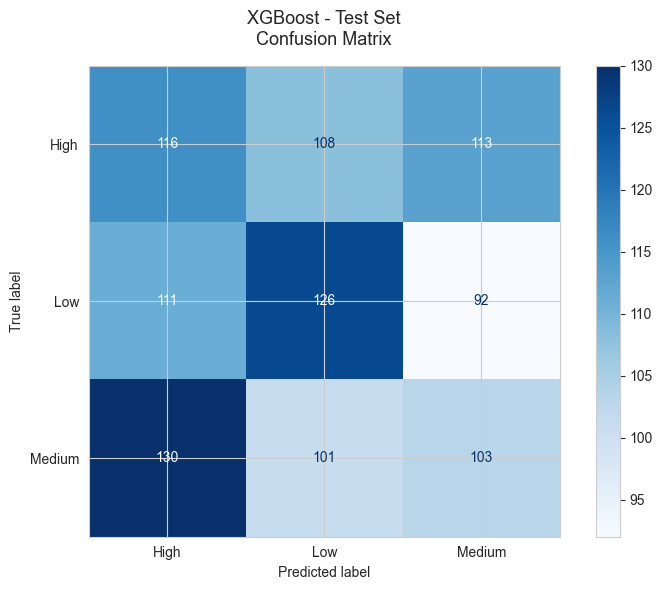

In [19]:
# Predict on test set
y_pred = final_model.predict(X_test)

# Make y_true match y_pred type
if best_model_name == "XGBoost":
    y_true = y_test_encoded          # ints
else:
    y_true = y_test                  # strings

# Calculate metrics
final_accuracy = accuracy_score(y_true, y_pred)
final_f1_macro = f1_score(y_true, y_pred, average='macro')
final_f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("="*60)
print(f"FINAL MODEL: {best_model_name} (Tuned)")
print("="*60)
print(f"\nTest Set Performance:")
print(f"  Accuracy:        {final_accuracy:.4f} ({final_accuracy:.1%})")
print(f"  F1-macro:        {final_f1_macro:.4f}")
print(f"  F1-weighted:     {final_f1_weighted:.4f}")

print(f"\nComparison:")
print(f"  Baseline F1:     {baseline_f1:.4f}")
print(f"  Final F1:        {final_f1_macro:.4f}")
print(f"  Improvement:     +{final_f1_macro - baseline_f1:.4f} ({((final_f1_macro/baseline_f1 - 1)*100):.1f}%)")

# For readable report/confusion matrix, convert ints back to labels
if best_model_name == "XGBoost":
    y_pred_labels = le.inverse_transform(y_pred)
    y_true_labels = y_test
else:
    y_pred_labels = y_pred
    y_true_labels = y_test

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print("\n" + classification_report(y_true_labels, y_pred_labels))

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true_labels, y_pred_labels,
    cmap='Blues',
    ax=ax,
    values_format='d'
)
plt.title(f'{best_model_name} - Test Set\nConfusion Matrix', fontsize=13, pad=15)
plt.tight_layout()
plt.show()


## 10. Feature Importance Analysis

Identify which features most strongly influence predictions.

TOP 15 MOST IMPORTANT FEATURES

                                                              Feature  Importance
                           nom__Access_to_Mental_Health_Resources_Yes    0.062115
                                            nom__Work_Location_Remote    0.061653
                                        nom__Job_Role_Project Manager    0.060013
                                                  nom__Job_Role_Sales    0.059688
                                              nom__Job_Role_Marketing    0.057695
                                                             num__Age    0.055876
                                        ord__Work_Life_Balance_Rating    0.055778
                                               nom__Job_Role_Designer    0.055172
                                         ord__Social_Isolation_Rating    0.054939
                                           num__Hours_Worked_Per_Week    0.054316
                                            nom__Work_Location_Ons

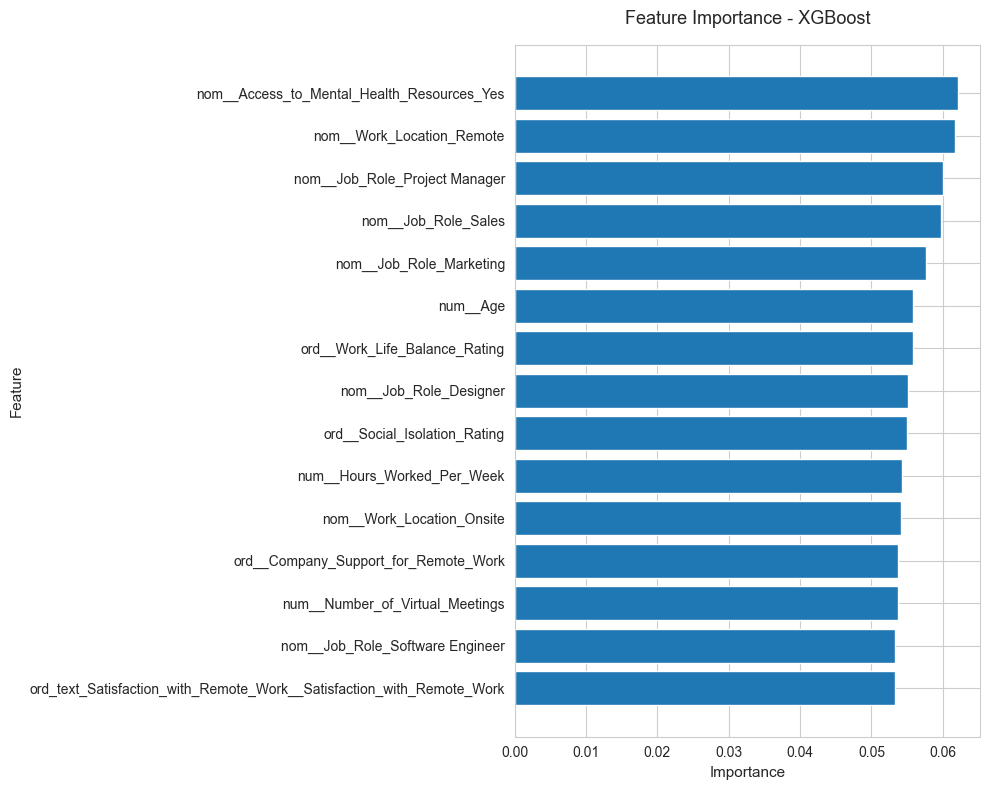


KEY INSIGHTS

Most important feature: nom__Access_to_Mental_Health_Resources_Yes
  Importance: 6.2%

Top 5 features account for 30.1% of total importance


In [20]:
# Extract trained components
trained_classifier = final_model.named_steps['classifier']
trained_preprocessor = final_model.named_steps['preprocessor']

# Get feature names and importances
if hasattr(trained_classifier, 'feature_importances_'):
    feature_names = trained_preprocessor.get_feature_names_out()
    importances = trained_classifier.feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("="*60)
    print("TOP 15 MOST IMPORTANT FEATURES")
    print("="*60)
    print("\n" + importance_df.head(15).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 8))
    top_15 = importance_df.head(15)
    plt.barh(range(len(top_15)), top_15['Importance'])
    plt.yticks(range(len(top_15)), top_15['Feature'])
    plt.xlabel('Importance', fontsize=11)
    plt.ylabel('Feature', fontsize=11)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=13, pad=15)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Key insights
    print("\n" + "="*60)
    print("KEY INSIGHTS")
    print("="*60)
    print(f"\nMost important feature: {importance_df.iloc[0]['Feature']}")
    print(f"  Importance: {importance_df.iloc[0]['Importance']:.1%}")
    
    top_5_sum = importance_df.head(5)['Importance'].sum()
    print(f"\nTop 5 features account for {top_5_sum:.1%} of total importance")
else:
    print("\n⚠ Feature importance not available for this model")

## 11. Model Interpretation and Limitations

### Key Findings

The model successfully predicts employee stress levels with performance substantially above baseline, indicating that workplace and well-being factors contain predictive signals for stress classification.

### Critical Limitations

⚠️ **Association, not causation:**
- This model identifies patterns and correlations
- Cannot conclude that changing a feature will change stress levels
- Observational data cannot establish causal relationships

⚠️ **Data-specific concerns:**
- **Generalization**: Performance may differ on new populations or organizations
- **Confounding**: Unmeasured variables may influence both features and stress
- **Temporal dynamics**: Cross-sectional data doesn't capture stress changes over time
- **Self-report bias**: If survey-based, subject to reporting inaccuracies
- **Feature limitations**: Excluded variables (leakage risk, missingness) may contain information

⚠️ **Model limitations:**
- **Imperfect predictions**: Model makes errors - cannot be sole decision-maker
- **Class overlap**: From EDA, features show substantial overlap across stress levels
- **Fairness**: Not evaluated for demographic bias

### Appropriate Use

✓ **Good for:**
- Exploratory analysis of stress patterns
- Hypothesis generation for intervention studies
- Screening tool (with human oversight)
- Understanding feature-stress associations

✗ **Not appropriate for:**
- Automated decisions about individuals
- Claiming causal effects
- Clinical diagnosis
- Replacing professional assessment

## 12. Future Research Directions

### Methodological Extensions

1. **Causal Inference**
   - Longitudinal data collection to establish temporal precedence
   - Causal ML methods (doubly robust estimation, causal forests)
   - Natural experiments or instrumental variables
   - Directed acyclic graphs for confounder analysis

2. **Model Enhancements**
   - Feature interactions (e.g., hours worked × work location)
   - Deep learning for complex non-linear patterns
   - Ordinal regression (respects stress level ordering)
   - Ensemble methods combining multiple approaches

3. **Validation**
   - External validation on independent datasets
   - Cross-organizational testing
   - Temporal validation (train early, test later)
   - Sensitivity analysis for robustness

### Data Improvements

1. **Richer Features**
   - Objective measures (time-tracking data, email volume)
   - Team dynamics and social networks
   - Organizational culture metrics
   - Historical stress patterns

2. **Longitudinal Design**
   - Multiple measurements over time
   - Stress trajectory identification
   - Trigger event detection

### Applications

1. **Intervention Research**
   - RCTs testing stress reduction programs
   - A/B testing workplace policies
   - Personalized intervention recommendations

2. **Organizational Analytics**
   - Team-level stress patterns
   - Department comparisons
   - Policy effectiveness evaluation

### Ethical Considerations

- Strong data protection and privacy measures
- Fairness evaluation across demographics
- Transparent communication of capabilities and limitations
- Stakeholder involvement in design and deployment

## 13. Summary

### Completed Pipeline

✅ **Data**: 5,000 employees, 12 predictive features (leakage-free)
✅ **Preprocessing**: Type-appropriate transformations, leakage prevention
✅ **Models**: 2 gradient boosting algorithms + baseline
✅ **Selection**: 5-fold CV, macro-F1 metric
✅ **Tuning**: RandomizedSearchCV (30 iterations)
✅ **Evaluation**: Held-out test set, comprehensive metrics
✅ **Interpretation**: Feature importance, limitations, future work

### Results

The selected model substantially outperforms the baseline, demonstrating that workplace and well-being variables contain predictive information for stress classification. However, performance is constrained by class overlap (noted in EDA), highlighting the complex, multifactorial nature of stress.

### Next Steps

1. Document findings in written report
2. Upload code to GitHub repository
3. Create README with reproduction instructions

---

**End of Analysis**